# Histogram of Oriented Gradients: Step-by-Step
* Author: Johannes Maucher
* Last update: 03.03.2021

Histogram of Oriented Gradients (HoG) is a global feature representation, in the sense that one feature description is calculated for the entire image or an image-patch. The descriptor is a vector which contains many histograms. Each histogram belongs to a local area within the image and counts the frequency of gradient-directions in this local area.

In images gradients in x- and y-direction, can easily be calculated by filters like *Prewitt*, *Sobel*, or the first-order derivative of a Gaussian. The magnitude of a gradient is large at edges and the orientation of the gradient-vector indicates the orientation of edges. Hence HoG-features encode the structure of objects in an image and can be applied for all detection and recognition tasks, for which structure-information is assumed to be crucial. 


HoG is particularly well suited for human detection and tracking. For this task it has initially be investigated in [Dalal and Triggs; Histograms of Oriented Gradients for Human Detection](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf).

In this notebook the calculation of a HoG-descriptor of an image-patch is demonstrated step-by-step. In follow-up notebooks the application of HoG-descriptors for the detection of pedestrians in images and for tracking of pedestrians in videos are demonstrated. 

In [1]:
#from __future__ import print_function
#from imutils.object_detection import non_max_suppression
#from imutils import paths
import numpy as np
#import imutils
import cv2
#from PIL import Image
from matplotlib import pyplot as plt
np.set_printoptions(precision=2,suppress=True)

<class 'numpy.ndarray'>


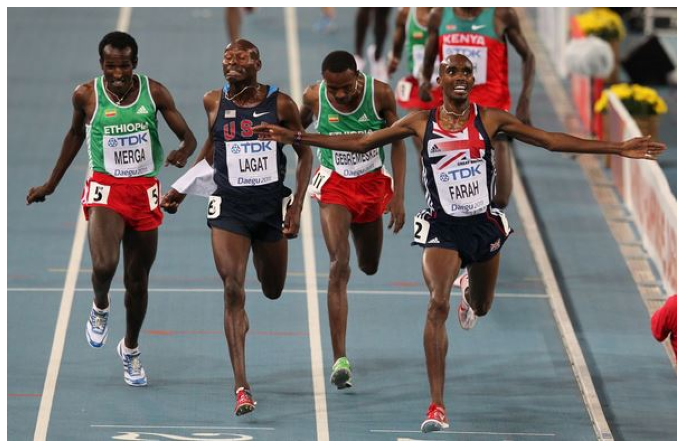

In [2]:
imagePath="../Data/mo.png"
image = cv2.imread(imagePath)
print(type(image))
plt.figure(figsize=(12,10))
plt.axis("off")
plt.imshow(image)
plt.show()

## Extract Image Patch
HoG are calculated for image patches (i.e. sub-windows within the image). For example in a pedestrian-detection task a window is slided over the entire image. At each window-position the HoG-descriptor is calculated. This HoG-descriptor is then passed to a binary classifier, e.g. a Support-Vector-Machine (SVM), which determines whether or not there is a pedestrian in the current sub-window. 

In this exercise a patch-size of 128 rows and 64 columns is applied. In the code cell below the upper-left corner of the patch is at position `Location`. The patch is further subdivided into regions of size $8 \times 8$. For each of these region an individual histogram is calculated. The entire HoG-descriptor of the patch is the concatenation of all regional histograms within the patch. 

> **Note:** The origin of the numpy-array, to which the image has been imported by `cv2.imread()` is at the upper-left corner. The first axis corresponts to the vertical, the second to the horizontal and the third to the channel-dimension.

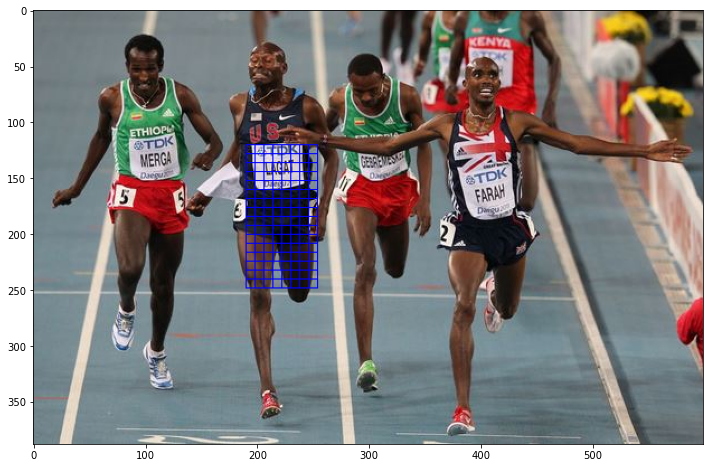

In [3]:
np_im=image.copy()
#Location=[0,0]
Location=[120,190]  # first component is vertical axis, second is horizontal axis 
PatchSize=[128,64]  # first component is vertical axis, second is horizontal axis
numlinesY=int(PatchSize[0]/8)
numlinesX=int(PatchSize[1]/8)

#Draw frame around selected patch
plt.figure(figsize=(12,10))
cv2.rectangle(np_im, (Location[1], Location[0]), 
                      (Location[1]+PatchSize[1],Location[0]+PatchSize[0]), 
                     (0, 0, 255), 1)

#Draw region boundaries within the patch
for x in range(numlinesX):
    cv2.line(np_im,(Location[1]+8*(x+1),Location[0]),
                   (Location[1]+8*(x+1),Location[0]+PatchSize[0]),
                   (0, 0, 255), 1)
for y in range(numlinesY):
    cv2.line(np_im,(Location[1],Location[0]+8*(y+1)),
                   (Location[1]+PatchSize[1],Location[0]+8*(y+1)),
                   (0, 0, 255), 1)
plt.imshow(np_im)
plt.show()

## Calculate Gradient
### Apply Sobel Filter to calculate partial derivations
For each of the 3 channels the derivation in x- and y-direction is calculated by applying the *Sobel-filter*.

In [4]:
np_im2=image.copy()
gx = cv2.Sobel(np_im2, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(np_im2, cv2.CV_32F, 0, 1, ksize=1)

In [5]:
print(gx.shape)
print(gy.shape)

(388, 599, 3)
(388, 599, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


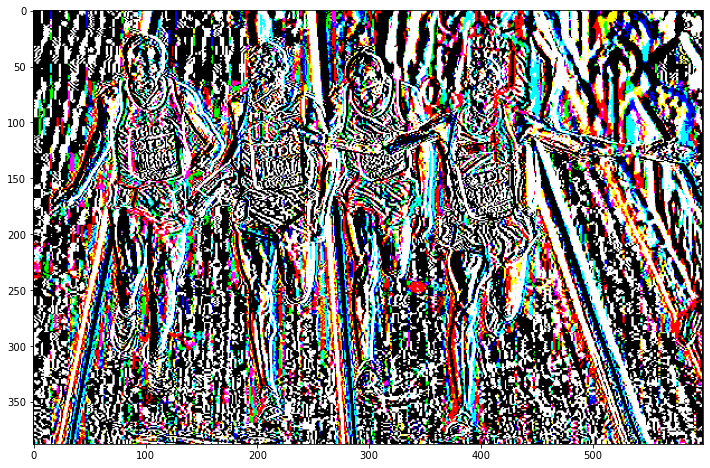

In [6]:
plt.figure(figsize=(12,10))
plt.imshow(gx,)
plt.show()

In [7]:
gx.shape

(388, 599, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


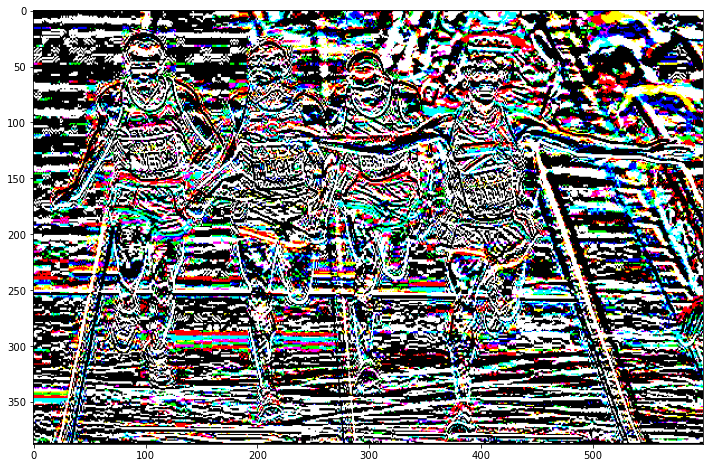

In [8]:
plt.figure(figsize=(12,10))
plt.imshow(gy)
plt.show()

### Analyse Pixels and Gradients in a $8 \times 8$ region 
For the upper left $8 \times 8$-region of the selected patch the pixel values of channel `Chan` are displayed and visualized in the following code cells. There is a vertical edge in within this region. Hence there should be high values for the gradients in direction of *x*. 

> **Note:** In this notebook an angle of 0 degrees points to the right and an angle of 90 degrees points to the top.

In [9]:
Chan=0  # Channel to be used for visualisation
W=8     # Region-width and -height

Pixel values in the selected channel at the selected region:

In [10]:
print(np_im2[Location[0]:Location[0]+W,Location[1]:Location[1]+W,Chan])

[[ 30  17  31  26 102 114  98 102]
 [ 47  45  36  30  50 133 235 244]
 [ 30  31  59  56   0  82 232 210]
 [ 39  36  11  33   0  64 222 195]
 [ 44  34  51  52  23  72 226 223]
 [ 37  29  47  28  11  40 201 233]
 [ 49  51  23  22  16  39 203 231]
 [ 25  31  57  53  14  25 193 217]]


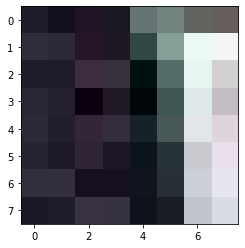

In [11]:
plt.imshow(np_im2[Location[0]:Location[0]+W,Location[1]:Location[1]+W])
plt.show()

Gradient $g_x$ in x-direction of the selected channel:

In [12]:
print(gx[Location[0]:Location[0]+W,Location[1]:Location[1]+W,Chan])

[[-15.   1.   9.  71.  88.  -4. -12.  25.]
 [  2. -11. -15.  14. 103. 185. 111.  13.]
 [  1.  29.  25. -59.  26. 232. 128. -15.]
 [ -4. -28.  -3. -11.  31. 222. 131.  -9.]
 [ -8.   7.  18. -28.  20. 203. 151.   0.]
 [ -3.  10.  -1. -36.  12. 190. 193.  30.]
 [ 12. -26. -29.  -7.  17. 187. 192.  23.]
 [ 10.  32.  22. -43. -28. 179. 192.  33.]]


Gradient $g_y$ in y-direction of the selected channel:

In [13]:
print(gy[Location[0]:Location[0]+W,Location[1]:Location[1]+W,Chan])

[[  31.   23.    8.    4.   26.   99.  165.  152.]
 [   0.   14.   28.   30. -102.  -32.  134.  108.]
 [  -8.   -9.  -25.    3.  -50.  -69.  -13.  -49.]
 [  14.    3.   -8.   -4.   23.  -10.   -6.   13.]
 [  -2.   -7.   36.   -5.   11.  -24.  -21.   38.]
 [   5.   17.  -28.  -30.   -7.  -33.  -23.    8.]
 [ -12.    2.   10.   25.    3.  -15.   -8.  -16.]
 [ -16.  -37.    5.   16.   32.    1.  -27.    8.]]


### Magnitude and Angle of the Gradients
The magnitude and the direction of the gradient can be calculated as follows:

$$
|g| = \sqrt{g_x^2+g_y^2}
$$
$$
\Theta = arctan\left( \frac{g_y}{g_x}\right)
$$

For this calculation *opencv*'s `cartToPolar()`-function can be applied:

In [14]:
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
print(mag.shape)
print(angle.shape)

(388, 599, 3)
(388, 599, 3)


For ease of visualization, magnitude and angle are represented as integers:

In [15]:
mag=mag.astype(int)
angle=angle.astype(int)

Gradient-magnitude of the selected channel and region:

In [16]:
print(mag[Location[0]:Location[0]+W,Location[1]:Location[1]+W,Chan])

[[ 34  23  12  71  91  99 165 154]
 [  1  17  31  33 144 187 174 108]
 [  8  30  35  59  56 242 128  51]
 [ 14  28   8  11  38 222 131  15]
 [  8   9  40  28  22 204 152  38]
 [  5  19  28  46  13 192 194  31]
 [ 16  26  30  25  17 187 192  28]
 [ 18  48  22  45  42 179 193  33]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


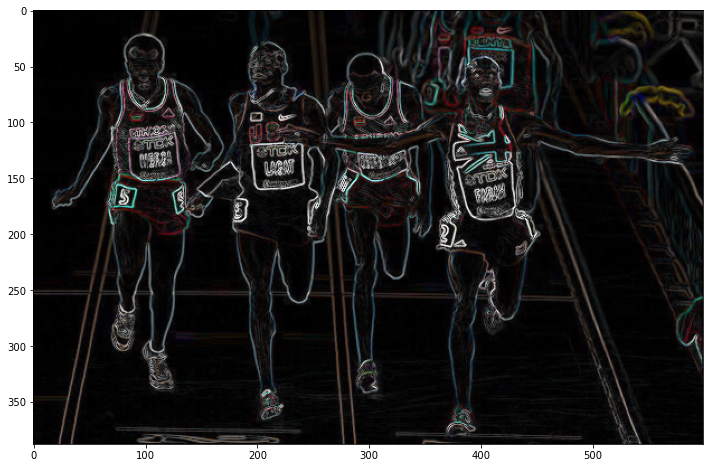

In [17]:
plt.figure(figsize=(12,10))
plt.imshow(mag)
plt.show()

In [18]:
mag.shape

(388, 599, 3)

## Apply max-operator over channels

Up to now gradients have been calculated for all channels individually. For calculating the HOG-descriptor, at each pixel-position the channel with the highest gradient at this position is determined. Only the gradients of the locally strongest channel are applied in the HoG-descriptor.

The array `maxChan`, as calculated below, contains for each pixel the channel with the highest magnitude at the pixel's position.

In [19]:
maxChan=np.argmax(mag,axis=2)
print(maxChan.shape)

(388, 599)


As shown below, at the upper-left pixel in the selected patch channel 0 has the strongest gradient. One pixel below, the highest gradient-magnitude is in channel 1. 

In [20]:
print(maxChan[Location[0]:Location[0]+W,Location[1]:Location[1]+W])

[[0 0 0 1 1 1 1 1]
 [1 1 2 1 1 0 0 2]
 [1 0 0 0 1 0 0 1]
 [1 1 2 0 1 1 0 1]
 [1 0 2 0 1 0 0 1]
 [1 0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0 0]
 [0 0 1 0 0 1 2 2]]


Calculate a 2-dimensional array, which contains only the **gradient-magnitude** of the locally *strongest* channel (strongest=channel with highest gradient). 

In [21]:
maxmag=np.zeros(maxChan.shape)
for r in range(maxChan.shape[0]):
    for c in range(maxChan.shape[1]):
        maxmag[r,c]=mag[r,c,maxChan[r,c]]
print(maxmag.shape)

(388, 599)


Visualisation of the maximum Gradient:

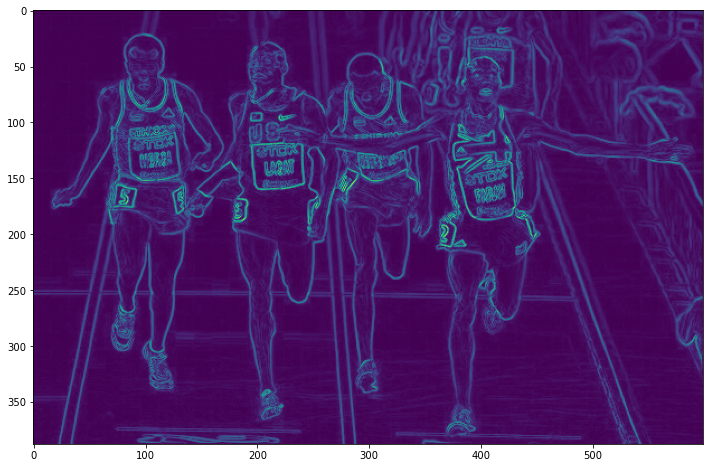

In [22]:
plt.figure(figsize=(12,10))
plt.imshow(maxmag)
plt.show()

Calculate a 2-dimensional array, which contains only the **gradient-angles** of the locally *strongest* channel (strongest=channel with highest gradient). 

In [23]:
maxangle=np.zeros(maxChan.shape)
for r in range(maxChan.shape[0]):
    for c in range(maxChan.shape[1]):
        maxangle[r,c]=angle[r,c,maxChan[r,c]]
print(maxangle.shape)

(388, 599)


Strongest gradient-magnitudes in the selected region:

In [24]:
print(maxmag[Location[0]:Location[0]+W,Location[1]:Location[1]+W])

[[ 34.  23.  12.  95. 115. 130. 203. 184.]
 [  3.  27.  32.  54. 168. 187. 174. 120.]
 [  9.  30.  35.  59.  89. 242. 128.  77.]
 [ 15.  39.  10.  11.  63. 227. 131.  50.]
 [ 11.   9.  42.  28.  44. 204. 152.  50.]
 [  7.  19.  28.  46.  32. 192. 194.  31.]
 [ 16.  33.  34.  27.  32. 189. 192.  28.]
 [ 18.  48.  24.  45.  42. 181. 195.  35.]]


Strongest gradient-angles in the selected region:

In [25]:
print(maxangle[Location[0]:Location[0]+W,Location[1]:Location[1]+W])

[[115.  87.  41.   0.  21.  97. 100.  87.]
 [180. 154. 126.  27. 323. 350.  50.  92.]
 [237. 342. 315. 177. 313. 343. 354. 228.]
 [129. 175. 216. 199.  15. 354. 357. 176.]
 [199. 315.  67. 190.  19. 353. 352. 135.]
 [140.  59. 267. 219. 334. 350. 353.  14.]
 [315. 173. 154.  77. 354. 353. 357. 325.]
 [302. 310.  34. 159. 131. 357. 351.  17.]]


## Create Histogram of single $8 \times 8$-region

For each $8 \times 8$-region of the selected patch a 9-bin histogram is calculated. The bin-centers are 

$$0°,20°,40°,60°,80°,100°,120°,140°,160°.$$

Gradient angles $\Theta$ with a value of $\Theta>180°$ are mapped to their opposite direction $\Theta'=\Theta-180°$. 

In [26]:
def anglemapper(x):
    if x >=180:
        return x-180
    else:
        return x

In [27]:
vfunc = np.vectorize(anglemapper)
mappedAngles=(vfunc(maxangle))
print(mappedAngles[Location[0]:Location[0]+W,Location[1]:Location[1]+W])

[[115.  87.  41.   0.  21.  97. 100.  87.]
 [  0. 154. 126.  27. 143. 170.  50.  92.]
 [ 57. 162. 135. 177. 133. 163. 174.  48.]
 [129. 175.  36.  19.  15. 174. 177. 176.]
 [ 19. 135.  67.  10.  19. 173. 172. 135.]
 [140.  59.  87.  39. 154. 170. 173.  14.]
 [135. 173. 154.  77. 174. 173. 177. 145.]
 [122. 130.  34. 159. 131. 177. 171.  17.]]


After this mapping into the range $\left[ 0,180 \right]$, each of the 64 gradient-angles in the region contributes to one or two bins of the histogram as follows:

* If the gradient-angle $\Theta_{ij}$ is equal to one of the 9 bin-centers, then position $i,j$ adds the value $|g_{ij}|$ to the bin with center $\Theta_{ij}$, where $|g_{ij}|$ is the gradient-magnitude at position $i,j$.

* If the gradient-angle $\Theta_{ij}$ lies between two bin-centers, where $\Theta_L$ is the next lower and $\Theta_R$ ist the next higher bin-center, then position $i,j$ adds 
    * the value $|g_{ij}| \cdot r$ to the bin with center $\Theta_R$, and
    * the value $|g_{ij}| \cdot (1-r)$ to the bin with center $\Theta_L$,

    where 

    $$r=\frac{\Theta_{ij}-\Theta_L}{20}.$$
    
    Due to the circular nature of angles, the next higher bin center $\Theta_R$ for all angles $160°<\Theta_{ij}<180°$ is $0°$.

 **Example:** Assume that at a given pixel the gradient-magnitude is $|g|=40$ and the gradient-angle is $325°$. The gradient-angle is mapped to $\Theta=325-180=145$. The next lower bin-center is $\Theta_L=140$, the next higher bin-center is $\Theta_L=160$. This gradient contributes a value of $0.25 \cdot 40 = 10$ to the bin centered at $\Theta_R=160$ and a value of $0.75 \cdot 40 = 30$ to the bin centered at $\Theta_L=140$.

The function `createHist()`, as defined in the following code cell, calculates for the gradient-angles `AngArray` and the gradient magnitudes `MagArray` of a given array the corresponding histogram.

In [28]:
def createHist(AngArray,MagArray,BS=20,BINS=9):
    hist=np.zeros(BINS)
    for r in range(AngArray.shape[0]):
        for c in range(AngArray.shape[1]):
            #print(AngArray[r,c])
            binel,rem = np.divmod(AngArray[r,c],BS)
            weight0=rem*1.0/BS
            weight1=1-weight0
            delta0=MagArray[r,c]*weight0
            delta1=MagArray[r,c]*weight1
            bin0=int(binel)
            bin1=np.mod(bin0+1,BINS)
            hist[bin0]+=delta0
            hist[bin1]+=delta1
    return hist         

Next, we apply this function `createHist()` for calculating the histogram of the upper left region in the selected patch:

In [29]:
spotAngles=mappedAngles[Location[0]:Location[0]+W,Location[1]:Location[1]+W]
spotMag=maxmag[Location[0]:Location[0]+W,Location[1]:Location[1]+W]
spotHist=createHist(spotAngles,spotMag)
print('Gradient histogram of the selected region:')
print(spotHist)

Gradient histogram of the selected region:
[1183.45  238.75  299.95  184.55  296.1   245.75  417.1   288.45 1849.9 ]


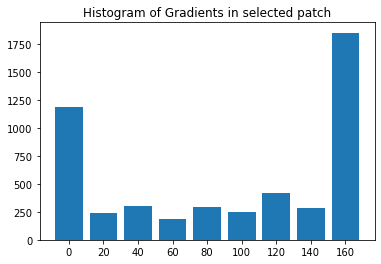

In [30]:
plt.bar(range(9),spotHist)
plt.xticks(range(9),[0,20,40,60,80,100,120,140,160])
plt.title("Histogram of Gradients in selected patch")
plt.show()

## Normalization

The historgrams of gradients must be normalized in order to make them robust with respect to overall lighting. For example, consider the case, where a stronger lighting of the scene yields a doubling of all pixel values. Then also the gradient-magnitudes and thus the histogram-values will be doubled. In order to avoid this a *L2-normalization* is applied. However, this normalization is not processed across a single histogram but across a *super-region* of size $16 \times 16$, which is covered by 4 histograms.

The following code cells draws the first two super-regions in the upper-left part of the considered patch. Each super-region contains $2 \times 2$ regions of size $8 \times 8$. First a 36-Bin normalized histogram is calculated for the green super-region. Then the window is shifted by 8 pixels to the right to the position of the red super-region and so on. All in all there will be $7 \times 15 =105$ super-region positions within this patch, resulting in a HoG-descriptor of length $105 \times 36 = 7380 Bins.$

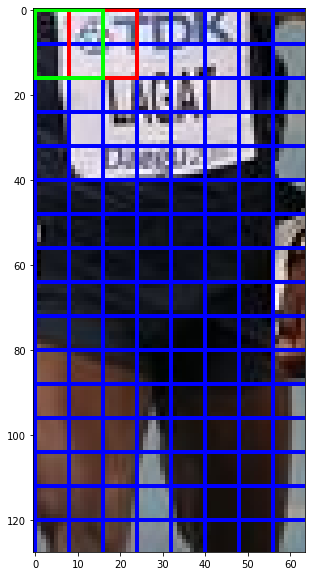

In [31]:
patch = np_im[Location[0]:Location[0]+PatchSize[0],Location[1]:Location[1]+PatchSize[1]].copy()
SR=16
plt.figure(figsize=(14,10))
cv2.rectangle(patch, (W, 0), (W+SR,SR),(255, 0, 0), 1)
cv2.rectangle(patch, (0, 0), (SR,SR),(0, 255, 0), 1)
plt.imshow(patch)
plt.show()

In the following code-cells the normalized 36-Bin histogram for the green super-region is calculated. 

First, the four 9-Bin histograms for the regions within the green super-region are obtained: 

In [32]:
hist11=spotHist
print(hist11)
spotAngles=mappedAngles[Location[0]:Location[0]+W,Location[1]+W:Location[1]+2*W]
spotMag=maxmag[Location[0]:Location[0]+W,Location[1]+W:Location[1]+2*W]
hist12=createHist(spotAngles,spotMag)
print(hist12)
spotAngles=mappedAngles[Location[0]+W:Location[0]+2*W,Location[1]:Location[1]+W]
spotMag=maxmag[Location[0]+W:Location[0]+2*W,Location[1]:Location[1]+W]
hist21=createHist(spotAngles,spotMag)
print(hist21)
spotAngles=mappedAngles[Location[0]+W:Location[0]+2*W,Location[1]+W:Location[1]+2*W]
spotMag=maxmag[Location[0]+W:Location[0]+2*W,Location[1]+W:Location[1]+2*W]
hist22=createHist(spotAngles,spotMag)
print(hist22)

[1183.45  238.75  299.95  184.55  296.1   245.75  417.1   288.45 1849.9 ]
[ 305.6   649.05  548.    141.8  1021.6  1923.35  454.05  218.05  160.5 ]
[ 571.45  950.4    66.35    6.     19.2   113.7   148.35  116.65 1917.9 ]
[264.8  127.85  77.45 178.1  374.5  560.9  269.9  217.   260.5 ]


The four non-normalized histograms are visualized in the code-cell below:


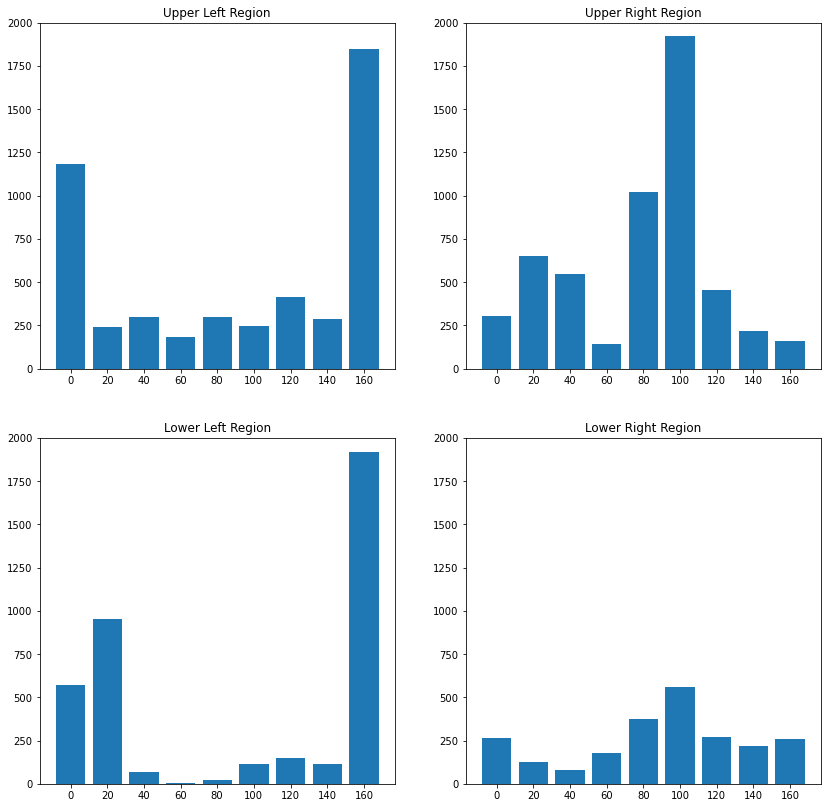

In [33]:
histList=[hist11,hist12,hist21,hist22]
titles=["Upper Left","Upper Right","Lower Left","Lower Right"]
plt.figure(figsize=(14,14))
i=1
for h in histList:
    plt.subplot(2,2,i)
    plt.title(titles[i-1]+" Region")
    plt.bar(range(9),h)
    plt.xticks(range(9),[0,20,40,60,80,100,120,140,160])
    plt.ylim((0,2000))
    i+=1
    #plt.title("Histogram of Gradients in selected patch")
plt.show()
    

Next, L2-normalization is performed over a vector, which is the concatenation of all 4 histograms in the region:

In [34]:
histRegion=np.array([bin for hist in histList for bin in hist])
print("\nRaw Histogram of upper-left super-region:")
print(histRegion)

l2norm=np.sqrt(np.sum(histRegion**2))
print("\nL2-Norm:")
print(l2norm)
epsilon=1e-6 # define epsilon in order to prevent division by zero
histRegionNormed=histRegion/(l2norm+epsilon)
print("\nNormalized Histogram of upper-left super-region:")
print(histRegionNormed)


Raw Histogram of upper-left super-region:
[1183.45  238.75  299.95  184.55  296.1   245.75  417.1   288.45 1849.9
  305.6   649.05  548.    141.8  1021.6  1923.35  454.05  218.05  160.5
  571.45  950.4    66.35    6.     19.2   113.7   148.35  116.65 1917.9
  264.8   127.85   77.45  178.1   374.5   560.9   269.9   217.    260.5 ]

L2-Norm:
4122.47236133852

Normalized Histogram of upper-left super-region:
[0.29 0.06 0.07 0.04 0.07 0.06 0.1  0.07 0.45 0.07 0.16 0.13 0.03 0.25
 0.47 0.11 0.05 0.04 0.14 0.23 0.02 0.   0.   0.03 0.04 0.03 0.47 0.06
 0.03 0.02 0.04 0.09 0.14 0.07 0.05 0.06]


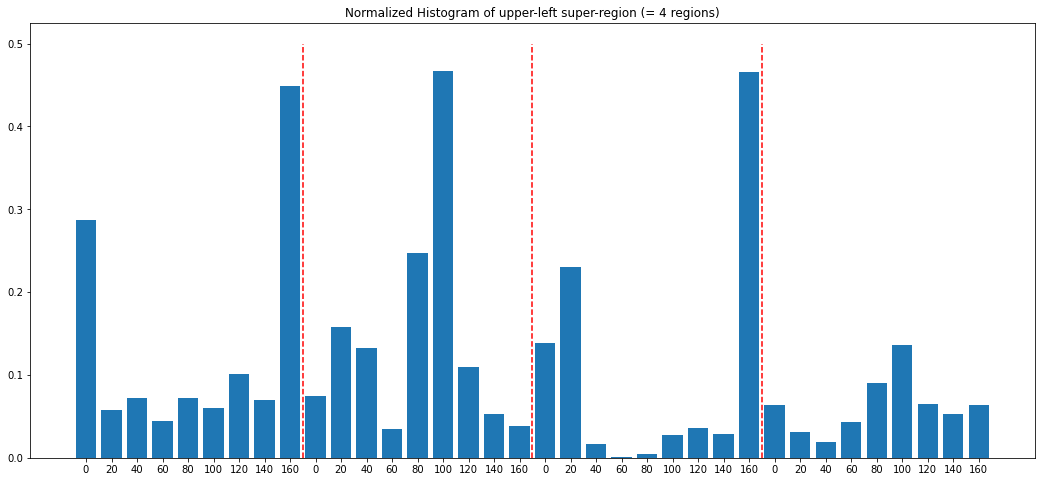

In [35]:
plt.figure(figsize=(18,8))
plt.bar(range(9*4),histRegionNormed)
plt.xticks(range(9*4),[0,20,40,60,80,100,120,140,160]*4)
for d in range(3):
    plt.plot([8.5+d*9,8.5+d*9],[0,0.5],"r--")
plt.title("Normalized Histogram of upper-left super-region (= 4 regions)")
plt.show()

## HoG-Descriptor for entire image patch
The HoG-descriptor of the entire image-patch consists of all normalized-region histograms within the patch. Each normalized region histogram contains 36 elements and is calculated as shown in the subsection above. In the subsection above the normalized histogram is calculated for the upper-left $16 \times 16$-window in the patch (green rectangle in the patch-visualization). Next, the window is shifted by 8 pixels to the right and the next 36 elements of the HoG-descriptor are calculated (red rectangle). The vertical-stepsize is also 8 pixels.

All in all for a patch of height $h$ and width $w$ the number of window positions, i.e. the number of 36-Bin normalized histograms is:

$$
\left( \frac{h-16}{8}+1 \right) \left( \frac{w-16}{8}+1 \right)
$$

In the example of this notebook, the patch-height is $h=128$ and it's width is $w=64$. The HoG-descriptor of the entire patch then contains 

$$ 
15 \cdot 7 \cdot 36 =  105 \cdot 36 = 3780 Bins.
$$

## Further References
* [HOG in scikit image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)